In [1]:
import sys
sys.path.append('..')

# standard
import json
from collections import defaultdict
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from statistics import median
from scipy import stats

# my lib
import STRING

In [2]:
def get_plots_outline(plots, boundFunc):
    # func can be: min, max, avg, median
    invertedArr = np.transpose(np.asarray(plots))
    boundPlot = [boundFunc(arr) for arr in invertedArr]
    return boundPlot

# init metadata

In [3]:
colors = {
    "L3E1_f1": "tab:blue",
    "L3E1_f2": "tab:olive",
    "L3E_f1Alt": "navy",
    "L3E_f2Alt": "gold",
    "L3": "tab:orange",
    "CN": "tab:green",
    "CRA": "tab:red",
    "CH2": "tab:brown",
    "Sim": "tab:purple",
    "rand": "tab:grey",
    "countP4": "black"
}

methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "random", "countP4", "L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]
methods_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "countP4", "L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]
abbrev_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "no.\n of $P_{4}$", "L3E'\n($f_{1}$)", "L3E'\n($f_{2}$)", "L3E\n($f_{1}$)", "L3E\n($f_{2}$)"]
label_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "no. of $P_{4}$", "L3E'($f_{1}$)", "L3E'($f_{2}$)", "L3E($f_{1}$)", "L3E($f_{2}$)"]

methods_names = dict(zip(methods, methods_map))
abbrevs = dict(zip(methods_map, abbrev_map))
labels = dict(zip(methods_map, label_map))

# Create STRING score dict

In [4]:
_, STRING_df = STRING.parse_STRING(ppiFile='./data/STRING/9606.protein.links.v11.0.txt'
        , typeFile='./data/STRING/9606.protein.actions.v11.0.txt'
        , uniProtMap='./data/UniProt/uniprot-taxonomy_9606_STRING.tab', root='../'
        , wFile_GGI='./data/parsed/STRING_homo_GGI.pkl', wFile_PPI='./data/parsed/STRING_homo_PPI.pkl')
STRING_PPI = ["\t".join(list(ppi)) for ppi in np.asarray(STRING_df[['nodeA', 'nodeB']])]
STRING_PPI += ["\t".join(list(ppi)[::-1]) for ppi in np.asarray(STRING_df[['nodeA', 'nodeB']])]
STRING_Score = list(np.asarray(STRING_df['score']))+list(np.asarray(STRING_df['score']))
STRING_scoreMap = dict(zip(STRING_PPI, STRING_Score))

# read predicted PPIs and map conf scores

In [5]:
methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "L3E1_f1", "L3E1_f2", "random"]
ds_names = ['STRING_human']
conf_scores = {}

for randSz in range(50, 100, 10):
    conf_scores[randSz] = defaultdict(dict)
    for ds in ds_names:
        for method in methods:
            conf_scores[randSz][ds][methods_names[method]] = []
            if randSz == 50:
                filename = "./linkPred_out_reduced/{}_{}_topPPI.json".format(method, ds)
            else:
                filename = "./linkPred_out_reduced/{}_{}_randSz{}_topPPI.json".format(method, ds, randSz)
            with open(filename, "r") as f:
                    tmpPPIs = json.loads(f.read())
                    for trial in range(len(tmpPPIs)):
                        conf_scores[randSz][ds][methods_names[method]].append(
                            [STRING_scoreMap["\t".join(i)] if "\t".join(i) in STRING_scoreMap else np.nan for i in tmpPPIs[trial]])

print(len(conf_scores[90]['STRING_human']["CN"]), len(conf_scores[90]['STRING_human']["CN"][0]))
print(len(conf_scores[90]['STRING_human']["rand"]), len(conf_scores[90]['STRING_human']["rand"][0]))

10 30861
10 30861


# Calculate just average of STRING conf score

In [7]:
methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "L3E1_f1", "L3E1_f2", "random"]

topAvgSTRScores, topStdSTRScores, topMeanScores = {}, {}, {}
for randSz in range(50, 100, 10):
    topAvgSTRScores[randSz], topStdSTRScores[randSz], topMeanScores[randSz] = defaultdict(dict), defaultdict(dict), defaultdict(dict)
    for ds in conf_scores[randSz]:
        for method in methods:
            method = methods_names[method]
            topMeanScore = []
            for trial in range(len(conf_scores[randSz][ds][method])):
                topMeanScore.append(np.mean(np.nan_to_num(
                    conf_scores[randSz][ds][method][trial][:int(len(conf_scores[randSz][ds][method][trial]))])))
            topMeanScores[randSz][ds][method] = topMeanScore
            topAvgSTRScores[randSz][ds][method] = np.mean(topMeanScore)
            topStdSTRScores[randSz][ds][method] = np.std(topMeanScore)

        topAvgSTRScores[randSz][ds] = dict(sorted(topAvgSTRScores[randSz][ds].items(), key=lambda item: item[1]))

print(topAvgSTRScores)
print(topStdSTRScores)

{50: defaultdict(<class 'dict'>, {'STRING_human': {'rand': 1.1682438256203542, 'CH2': 335.4534735948466, 'CN': 336.03458997323514, 'Sim': 364.8049843817844, 'L3': 379.29651263390514, 'CRA': 389.316627405108, 'L3E1_f2': 411.62213315014867, 'L3E1_f1': 452.88491999714853}}), 60: defaultdict(<class 'dict'>, {'STRING_human': {'rand': 0.9216906314553039, 'CN': 315.72242719429704, 'CH2': 326.28231378346635, 'L3': 357.89715946372877, 'Sim': 360.1997444205922, 'CRA': 391.4364028514723, 'L3E1_f2': 409.13420956701367, 'L3E1_f1': 424.2840728664588}}), 70: defaultdict(<class 'dict'>, {'STRING_human': {'rand': 0.6309916507350162, 'CH2': 293.3136920384952, 'CN': 298.58243846062453, 'Sim': 329.0134425326464, 'L3': 337.26358942786476, 'CRA': 368.49168961904456, 'L3E1_f2': 383.17259540088355, 'L3E1_f1': 396.9628095870732}}), 80: defaultdict(<class 'dict'>, {'STRING_human': {'rand': 0.4450439065487185, 'CN': 272.0879240789345, 'CH2': 273.9510875376689, 'Sim': 300.47443618158843, 'L3': 306.6987775833576, 

# scatter plot

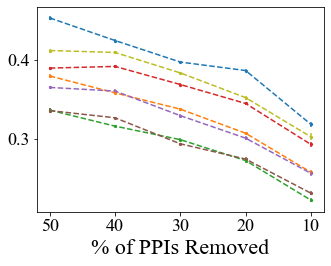

In [9]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"

fig = plt.figure(figsize=(4.7, 3.8))
ax = plt.gca()
ds = 'STRING_human'
for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
    ax.errorbar([randSz for randSz in range(50, 0, -10)]
                , [np.asarray(topAvgSTRScores[randSz][ds][method])/1000 for randSz in range(50, 100, 10)]
                , fmt='--', color=colors[method]
                , yerr=np.transpose(np.asarray(
                    [np.asarray(topStdSTRScores[randSz][ds][method])/1000 for randSz in range(50, 100, 10)]
                )))
    ax.scatter([randSz for randSz in range(50, 0, -10)]
                , [np.asarray(topAvgSTRScores[randSz][ds][method])/1000 for randSz in range(50, 100, 10)]
               , s=5, color=colors[method])
    ax.set_xlabel("% of PPIs Removed")
#ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
ax.set_xticks([randSz for randSz in range(50, 0, -10)])
ax.set_xlim(ax.get_xlim()[::-1])
#ax.set_ylabel("STRING conf. score")
plt.tight_layout()
plt.savefig('./img_experiments/full_conf_human.png'.format(randSz), dpi=300)
plt.show()

# AUC of scatter plot

In [10]:
# calculate AUC of scatter plot
auc_map = defaultdict(list)

ds = 'STRING_human'
for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]:
    for trial in range(10):
        X = [randSz/100 for randSz in range(50, 100, 10)]
        Y = [topMeanScores[randSz][ds][method][trial] for randSz in range(50, 100, 10)]
        auc_map[method].append(metrics.auc(X, Y))
        
sorted_mean_auc, err_auc = {}, {}
for method in auc_map:
    sorted_mean_auc[method] = np.mean(auc_map[method])
    err_auc[method] = np.std(auc_map[method])
sorted_mean_auc = dict(sorted(sorted_mean_auc.items(), key=lambda item: item[1]))

print(sorted_mean_auc)

{'rand': 0.27078380241051925, 'CN': 116.53382100242553, 'CH2': 117.66292026336423, 'Sim': 130.00209657518235, 'L3': 132.0122357011793, 'CRA': 144.52875524418243, 'L3E1_f2': 150.1025494027661, 'L3E1_f1': 159.28650277831065}


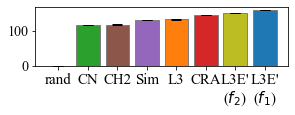

In [12]:
# auc bar plot
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=13)
plt.rcParams["font.family"] = "Times New Roman"

# auc bar plot
fig = plt.figure(figsize=(4.2,1.7))
xtick = [k for k in list(sorted_mean_auc.keys())]
plt.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[x] for x in xtick]
        , yerr=[err_auc[x] for x in xtick], capsize=5
        , color=[colors[x] for x in xtick], edgecolor='grey')

ax = plt.gca()
plt.tight_layout()
plt.savefig("./img_experiments/{}_confAUC_human.png".format(ds), dpi=300)

# p-val of avg STRING conf score

In [25]:
# p val
# sample to do: top 2 both to third, between top 2
pairs = [['L3E1_f1', 'L3E1_f2']]
for pair in pairs:
    pop1 = auc_map[pair[0]]
    pop2 = auc_map[pair[1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {}: {}".format(pair[0], pair[1], pVal))

L3E1_f1 L3E1_f2: 3.2530759809630115e-19


# Calculate moving average of STRING conf score

In [6]:
# only get top 10%
mm_win, mm_steps = 500, 10
mm_scores = {}

for randSz in range(50, 100, 10):
    mm_scores[randSz] = defaultdict(dict)
    for ds in ds_names:
        for method in methods:
            method = methods_names[method]
            mm_scores[randSz][ds][method] = []
            cur_scores = conf_scores[randSz][ds][method]
            for trial in range(len(cur_scores)):
                mm_scores[randSz][ds][method].append([])
                for step in range(0, int(len(cur_scores[trial]))-mm_win, mm_steps):
                    scores_win = cur_scores[trial][step:step+mm_win]
                    scores_win = np.nan_to_num(scores_win)
                    #if np.isnan(mean_scores): mm_scores[ds][method][-1].append(0)
                    #else: mm_scores[ds][method][-1].append(np.nanmean(scores_win))
                    mm_scores[randSz][ds][method][-1].append(np.mean(scores_win))

for randSz in range(50, 100, 10):
    print(len(mm_scores[randSz]['STRING_human']["CN"]), len(mm_scores[randSz]['STRING_human']["CN"][0]))

10 15381
10 12295
10 9209
10 6123
10 3037


# Create figure

In [25]:
mmMap = {}

for randSz in range(50, 100, 10):
    mmMap[randSz] = {}
    for ds in ds_names:
        mmMap[randSz][ds] = defaultdict(dict)
        for method in mm_scores[randSz][ds]:
            cur_mm_scores = mm_scores[randSz][ds][method]
            baseX = [i*mm_steps for i in range(len(cur_mm_scores[0]))]
            upperScore, lowerScore, medianScore = get_plots_outline(cur_mm_scores, max), get_plots_outline(cur_mm_scores, min), get_plots_outline(cur_mm_scores, median)
            mmMap[randSz][ds][method]['upperScore'] = upperScore
            mmMap[randSz][ds][method]['lowerScore'] = lowerScore
            mmMap[randSz][ds][method]['medianScore'] = medianScore
            mmMap[randSz][ds][method]['baseX'] = baseX
        
print(list(mmMap.keys()))

[50, 60, 70, 80, 90]


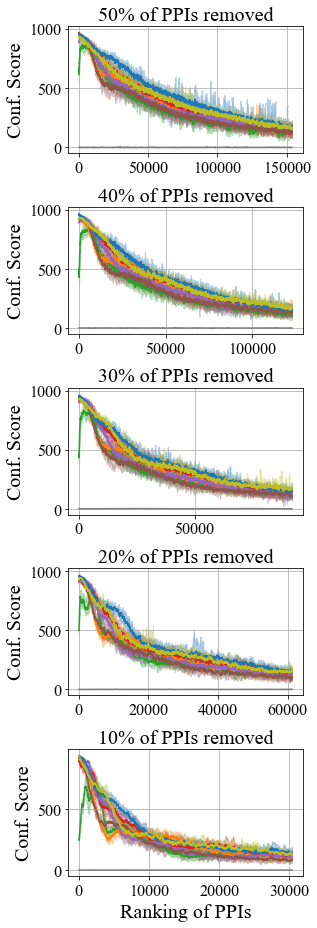

In [26]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
    
fig, axes = plt.subplots(5, 1, figsize=(4.5, 13))
for randSz in range(50, 100, 10):
    for ds in ['STRING_human']:
        ax = axes[int((randSz-50)/10)]

        for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]:
            ax.fill_between(mmMap[randSz][ds][method]['baseX'], mmMap[randSz][ds][method]['lowerScore']
                            , mmMap[randSz][ds][method]['upperScore']
                            , facecolor=colors[method], color=colors[method]
                            , alpha=0.3)
            ax.plot(mmMap[randSz][ds][method]['baseX'], mmMap[randSz][ds][method]['medianScore']
                    , color=colors[method], label=method)

        ax.set_ylabel("Conf. Score")
        ax.grid()
        #leg = ax.legend()
        #for line in leg.get_lines():
        #    line.set_linewidth(5.0)
        ax.set_title("{}% of PPIs removed".format(str(100-randSz)))
        
axes[-1].set_xlabel("Ranking of PPIs")
plt.tight_layout()
plt.savefig('./img_experiments/{}_mmConf_wRand.png'.format(ds), dpi=300)
plt.show()

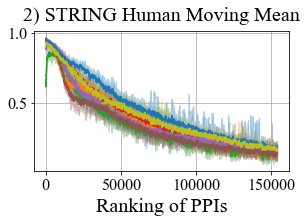

In [14]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"

fig = plt.figure(figsize=(4.5, 3.2))
ax = plt.gca()
randSz = 50

for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
    ax.fill_between(mmMap[randSz][ds][method]['baseX'], mmMap[randSz][ds][method]['lowerScore']
                    , mmMap[randSz][ds][method]['upperScore']
                    , facecolor=colors[method], color=colors[method]
                    , alpha=0.3)
    ax.plot(mmMap[randSz][ds][method]['baseX'], mmMap[randSz][ds][method]['medianScore']
            , color=colors[method], label=method)

#ax.set_ylabel("Conf. Score")
ax.grid()
ax.set_title("2) STRING Human Moving Mean".format(str(randSz)), pad=10)
        
ax.set_xlabel("Ranking of PPIs")
plt.tight_layout()
plt.savefig('./img_experiments/{}_mmConf_{}.png'.format(ds, randSz), dpi=300)
plt.show()

In [7]:
# calculate AUC of scatter plot
auc_map = {}

ds = 'STRING_human'
for randSz in range(50, 100, 10):
    auc_map[randSz] = {}
    for method in list(mm_scores[randSz][ds].keys()):
        auc_map[randSz][method] = []
        for trial in range(10):
            X = [i*mm_steps for i in range(len(mm_scores[randSz][ds][method][trial]))]
            Y = mm_scores[randSz][ds][method][trial]
            auc_map[randSz][method].append(metrics.auc(X, Y))
        
sorted_mean_auc, err_auc = {}, {}
for randSz in range(50, 100, 10):
    sorted_mean_auc[randSz], err_auc[randSz] = {}, {}
    for method in auc_map[randSz]:
        sorted_mean_auc[randSz][method] = np.mean(auc_map[randSz][method])
        err_auc[randSz][method] = np.std(auc_map[randSz][method])
    sorted_mean_auc[randSz] = dict(sorted(sorted_mean_auc[randSz].items(), key=lambda item: item[1]))

print(sorted_mean_auc)
print(err_auc)

{50: {'rand': 179636.503, 'CH2': 51488243.18, 'CN': 51640520.684499994, 'Sim': 56029486.856000006, 'L3': 58255988.3095, 'CRA': 59802846.720000006, 'L3E1_f2': 63241808.45250001, 'L3E1_f1': 69601104.7865}, 60: {'rand': 113382.501, 'CN': 38804282.748500004, 'CH2': 40002658.039000005, 'L3': 43908220.4145, 'Sim': 44199713.018, 'CRA': 48050442.6755, 'L3E1_f2': 50229316.89999999, 'L3E1_f1': 52093627.5855}, 70: {'rand': 58089.601, 'CH2': 26885751.983499996, 'CN': 27478502.247499995, 'Sim': 30204030.577500004, 'L3': 30963544.429499995, 'CRA': 33851444.272, 'L3E1_f2': 35198458.6, 'L3E1_f1': 36471401.70199999}, 80: {'rand': 26984.331, 'CH2': 16644630.594, 'CN': 16655525.7715, 'Sim': 18291405.243, 'L3': 18674355.928499997, 'CRA': 20994932.508, 'L3E1_f2': 21443342.130000003, 'L3E1_f1': 23560215.787000008}, 90: {'rand': 7662.984999999999, 'CN': 6769629.433, 'CH2': 6867435.500499999, 'Sim': 7637272.433499999, 'L3': 7694382.0735, 'CRA': 8769629.4645, 'L3E1_f2': 9059074.4615, 'L3E1_f1': 9538372.17}}
{5

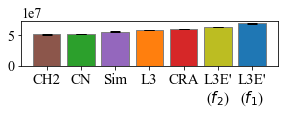

In [23]:
# auc bar plot
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=13)
plt.rcParams["font.family"] = "Times New Roman"

# auc bar plot
fig = plt.figure(figsize=(4.2,1.7))
xtick = [k for k in list(sorted_mean_auc[50].keys()) if k != 'rand']
plt.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[50][x] for x in xtick]
        , yerr=[err_auc[50][x] for x in xtick], capsize=5
        , color=[colors[x] for x in xtick], edgecolor='grey')

ax = plt.gca()
plt.tight_layout()
plt.savefig("./img_experiments/{}_mmConfAUC_human.png".format(ds), dpi=300)

In [28]:
# p val
# sample to do: top 2 both to third, between top 2
ds = 'STRING_human'
pairs = ['L3E1_f1', 'L3E1_f2']
pop1 = auc_map[50][pairs[0]]
pop2 = auc_map[50][pairs[1]]
pVal = stats.ttest_ind(pop1, pop2)[1]
print("{} {} {}: {}".format(ds, pairs[0], pairs[1], pVal))

STRING_human L3E1_f1 L3E1_f2: 1.2303372904626316e-19


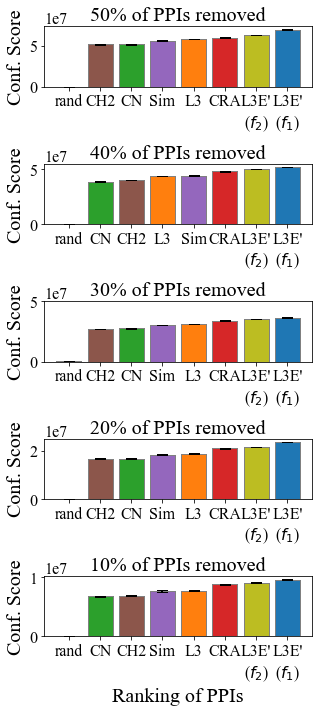

In [8]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
    
fig, axes = plt.subplots(5, 1, figsize=(4.7, 10))
for randSz in range(50, 100, 10):
    for ds in ['STRING_human']:
        ax = axes[int((randSz-50)/10)]

        for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]:
            xtick = [k for k in list(sorted_mean_auc[randSz].keys())]
            ax.bar([abbrevs[x] for x in xtick], [sorted_mean_auc[randSz][x] for x in xtick],
                    yerr=[err_auc[randSz][x] for x in xtick], capsize=5,
                    color=[colors[x] for x in xtick], edgecolor='grey')

        ax.set_ylabel("Conf. Score")
        #leg = ax.legend()
        #for line in leg.get_lines():
        #    line.set_linewidth(5.0)
        ax.set_title("{}% of PPIs removed".format(str(100-randSz)))
        if randSz == 70: ax.set_ylim([0, 50000000])
        
axes[-1].set_xlabel("Ranking of PPIs")
plt.tight_layout()
plt.savefig('./img_experiments/{}_mmConfAUC_wRand.png'.format(ds), dpi=300)
plt.show()

In [10]:
# p val
# sample to do: top 2 both to third, between top 2
for randSz in range (50, 100, 10):
    ds = 'STRING'
    i = int((randSz-50)/10)
    pairs = [['L3E1_f1', 'L3E1_f2'] for randSz in range(50, 100, 10)]
    pop1 = auc_map[randSz][pairs[i][0]]
    pop2 = auc_map[randSz][pairs[i][1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {} {} {}: {}".format(randSz, ds, pairs[i][0], pairs[i][1], pVal))

50 STRING L3E1_f1 L3E1_f2: 1.2303372904626316e-19
60 STRING L3E1_f1 L3E1_f2: 1.3571159578357517e-11
70 STRING L3E1_f1 L3E1_f2: 7.74531749200357e-15
80 STRING L3E1_f1 L3E1_f2: 7.617207767514951e-17
90 STRING L3E1_f1 L3E1_f2: 1.8999726880392175e-07


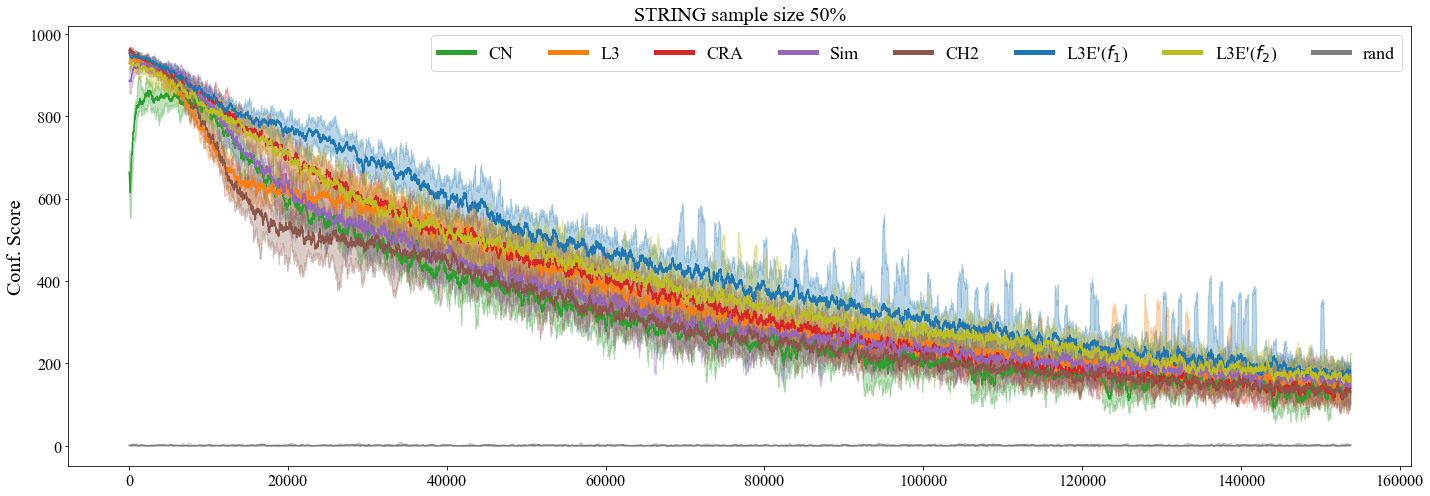

In [14]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
    
fig = plt.figure(figsize=(20, 7))
ax = plt.gca()
for randSz in range(50, 100, 10):
    for ds in ['STRING_human']:

        for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]:
            ax.fill_between(mmMap[randSz][ds][method]['baseX'], mmMap[randSz][ds][method]['lowerScore']
                            , mmMap[randSz][ds][method]['upperScore']
                            , facecolor=colors[method], color=colors[method]
                            , alpha=0.3)
            ax.plot(mmMap[randSz][ds][method]['baseX'], mmMap[randSz][ds][method]['medianScore']
                    , color=colors[method], label=labels[method])

        ax.set_ylabel("Conf. Score")
        #ax.grid()
        #leg = ax.legend()
        leg = ax.legend(ncol = len(ax.lines) )
        for line in leg.get_lines():
            line.set_linewidth(5.0)
        ax.set_title("STRING sample size {}%".format(str(randSz)))
        
        break
    break

#axes[-1].set_xlabel("Ranking of PPIs")
plt.tight_layout()
plt.savefig('./img_experiments/legend.png'.format(ds), dpi=300)
plt.show()